In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from part import Part, Recipe

parts_df = pd.read_excel("recipes.ods", sheet_name="Parts")
recipes_df = pd.read_excel("recipes.ods", sheet_name="Recipes")
print(parts_df.info())
print(recipes_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    16 non-null     object
 1   Kind    16 non-null     object
dtypes: object(2)
memory usage: 388.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Output       13 non-null     object 
 1   Output rate  13 non-null     int64  
 2   Input 1      13 non-null     object 
 3   Number 1     13 non-null     int64  
 4   Input 2      4 non-null      object 
 5   Number 2     4 non-null      float64
 6   Input 3      0 non-null      float64
 7   Number 3     0 non-null      float64
 8   Input 4      0 non-null      float64
 9   Number 4     0 non-null      float64
 10  Building     13 non-null     object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1

In [4]:
parts_list = {row["Name"]:Part(name=row["Name"], kind=row["Kind"]) for _, row in parts_df.iterrows()}
print(parts_list)


{'Iron Ore': Iron Ore, 'Iron Ingot': Iron Ingot, 'Iron Rod': Iron Rod, 'Iron Plate': Iron Plate, 'Reinforced Iron Plate': Reinforced Iron Plate, 'Screw': Screw, 'Rotor': Rotor, 'Modular Frame': Modular Frame, 'Smart Plating': Smart Plating, 'Copper Ore': Copper Ore, 'Copper Ingot': Copper Ingot, 'Copper Sheet': Copper Sheet, 'Wire': Wire, 'Cable': Cable, 'Limestone': Limestone, 'Concrete': Concrete}


In [5]:
# Process recipes:
for _, row in recipes_df.iterrows():

    inputs = []
    cleaned_row = row.dropna()
    for i in [1, 2, 3, 4]:
        try:
            inputs.append([cleaned_row[f"Input {i}"], cleaned_row[f"Number {i}"]])
        except KeyError:
            continue

    parts_list[row["Output"]].add_recipe(inputs, row["Output rate"], row["Building"])


In [6]:
for key, val in parts_list.items():
    print(f"Item: {val}")
    print("Recipes: ")
    for recipe in val.recipes:
        print(recipe)
    


Item: Iron Ore
Recipes: 
Item: Iron Ingot
Recipes: 
Input:
      30  Iron Ores
Output:
      30  Iron Ingots

Item: Iron Rod
Recipes: 
Input:
      15  Iron Ingots
Output:
      15  Iron Rods

Item: Iron Plate
Recipes: 
Input:
      30  Iron Ingots
Output:
      20  Iron Plates

Item: Reinforced Iron Plate
Recipes: 
Inputs:
      30  Iron Plates
    60.0  Screws
Output:
       5  Reinforced Iron Plates

Item: Screw
Recipes: 
Input:
      10  Iron Rods
Output:
      40  Screws

Item: Rotor
Recipes: 
Inputs:
      20  Iron Rods
   100.0  Screws
Output:
       4  Rotors

Item: Modular Frame
Recipes: 
Inputs:
       3  Reinforced Iron Plates
    12.0  Iron Rods
Output:
       2  Modular Frames

Item: Smart Plating
Recipes: 
Inputs:
       2  Reinforced Iron Plates
     2.0  Rotors
Output:
       2  Smart Platings

Item: Copper Ore
Recipes: 
Item: Copper Ingot
Recipes: 
Input:
      30  Copper Ores
Output:
      30  Copper Ingots

Item: Copper Sheet
Recipes: 
Input:
      20  Copper Ingots


In [7]:
# Creating a recipe graph
import networkx as nx

recipe_graph = nx.DiGraph()

for name, part in parts_list.items():
    recipe_graph.add_node(name)

for name, part in parts_list.items():
    for recipe in part.recipes:
        for item, number in recipe.inputs:
            recipe_graph.add_edge(item, name, number=number)


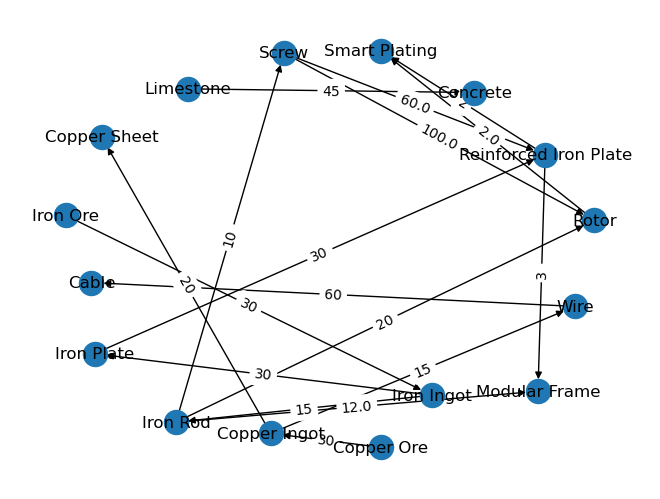

In [8]:
import matplotlib.pyplot as plt

positions = nx.spring_layout(recipe_graph, k=3)
nx.draw(recipe_graph, with_labels=True, pos=positions)
nx.draw_networkx_edge_labels(recipe_graph, pos=positions, edge_labels={(u, v): d["number"]
                                                                       for u, v, d in recipe_graph.edges(data=True)})
plt.show()

In [9]:
output = "Reinforced Iron Plate"
list(recipe_graph.predecessors(output))

['Iron Plate', 'Screw']

In [115]:
# Start moving backwards in the supply chain
# For each element in the supply chain, add ingredients to a dict based on the recipe and the number
# requested
part = parts_list["Modular Frame"]
recipe = part.recipes[0]
solved = False
ingredients = {part.name:{"required": recipe.outputs[0][1],
                          "multiplier": 0,
                          "supplied": 0,
                          "solved": False}}
print(ingredients)


{'Modular Frame': {'required': 2, 'multiplier': 0, 'supplied': 0, 'solved': False}}


In [128]:
from copy import deepcopy

def solve_supply_chain(outputs, integral=True):
    """ Output is a dict of the form {part:number}"""

    ingredients = {}

    for part, number in outputs.items():
        ingredients[part] = {"requirements":{"output": number},
                             "required": number,
                             "supplied": 0}

    all_solved = False
    while not all_solved:
        new_ingredients = deepcopy(ingredients)
        
        for item, status in ingredients.items():
            
            recipe = parts_list[item].get_default_recipe()
            new_status = new_ingredients[item]

            if recipe is None:
                new_status["supplied"] = status["required"]
                continue

            inputs = recipe.inputs
            output = recipe.outputs[0][1]

            new_status["solved"] = (status["supplied"] >= status["required"])

            if not new_status["solved"]:

                if integral:
                    new_status["multiplier"] = np.ceil(status["required"] / output)
                else:
                    new_status["multiplier"] = float(status["required"]) / output
                    
                new_status["supplied"] = output * new_status["multiplier"]
                new_status["inputs"] = {}

                for part, number in inputs:
                    if part in ingredients.keys():
                        new_ingredients[part]["requirements"][item] = number * new_status["multiplier"]
                    else:
                        new_ingredients[part] = {"requirements": {item: number * new_status["multiplier"]},
                                                 "required": number * new_status["multiplier"],
                                                 "supplied": 0}

                    new_status["inputs"][part] = new_status["multiplier"] * number

            

        ingredients = deepcopy(new_ingredients)
        all_solved = True
        for item, status in ingredients.items():
            status["required"] = sum([num for _, num in status["requirements"].items()])
            status["leftover"] = status["supplied"] - status["required"]
            status["solved"] = status["leftover"] >= 0
            all_solved &= (status["solved"])

    return ingredients

In [140]:
outputs = {"Reinforced Iron Plate": 10,
           }

ingredients = solve_supply_chain(outputs, integral=True)

for key, val in ingredients.items():
    recipe = parts_list[key].get_default_recipe()
    if recipe:
        print(f"{key} ({recipe.outputs[0][1]})")
    else:
        print(key)
    print(f"\tRequired: {val['required']}")
    try:
        print(f"\tMultiplier: {val['multiplier']}")
        print(f"\tSupplied: {val['supplied']}")
    except KeyError:
        continue


Reinforced Iron Plate (5)
	Required: 10
	Multiplier: 2.0
	Supplied: 10.0
Iron Plate (20)
	Required: 60.0
	Multiplier: 3.0
	Supplied: 60.0
Screw (40)
	Required: 120.0
	Multiplier: 3.0
	Supplied: 120.0
Iron Ingot (30)
	Required: 120.0
	Multiplier: 4.0
	Supplied: 120.0
Iron Rod (15)
	Required: 30.0
	Multiplier: 2.0
	Supplied: 30.0
Iron Ore
	Required: 120.0


In [139]:
print(ingredients)

{'Modular Frame': {'requirements': {'output': 2}, 'required': 2, 'supplied': 2.0, 'solved': True, 'multiplier': 1.0, 'inputs': {'Reinforced Iron Plate': 3.0, 'Iron Rod': 12.0}, 'leftover': 0.0}, 'Smart Plating': {'requirements': {'output': 5}, 'required': 5, 'supplied': 6.0, 'solved': True, 'multiplier': 3.0, 'inputs': {'Reinforced Iron Plate': 6.0, 'Rotor': 6.0}, 'leftover': 1.0}, 'Reinforced Iron Plate': {'requirements': {'Smart Plating': 6.0}, 'required': 6.0, 'supplied': 10.0, 'leftover': 4.0, 'solved': True, 'multiplier': 2.0, 'inputs': {'Iron Plate': 60.0, 'Screw': 120.0}}, 'Iron Rod': {'requirements': {'Modular Frame': 12.0, 'Rotor': 40.0, 'Screw': 50.0}, 'required': 102.0, 'supplied': 105.0, 'leftover': 3.0, 'solved': True, 'multiplier': 7.0, 'inputs': {'Iron Ingot': 105.0}}, 'Rotor': {'requirements': {'Smart Plating': 6.0}, 'required': 6.0, 'supplied': 8.0, 'leftover': 2.0, 'solved': True, 'multiplier': 2.0, 'inputs': {'Iron Rod': 40.0, 'Screw': 200.0}}, 'Iron Plate': {'requir